# Intro
This notebook code is used to apply the Self-Organizing Map (SOM) alghoritm to the Chandra Source Catalog (CSC) version 1. This is the first attempt to apply the SOM algorithm and the following code is specifically being used to test the features of the minisom package.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord
from astropy import units as u
from minisom import MiniSom
import pandas as pd
import numpy as np

Loading the raw and log-normalized datasets from CSV files into pandas DataFrames.

In [2]:
raw_dataset_path = './data/cluster_csc_simbad.csv'
dataset_path = './data/cluster_csc_simbad_log_normalized.csv'

# Load the dataset
raw_df = pd.read_csv(raw_dataset_path)
df = pd.read_csv(dataset_path)

/var/folders/lr/d8nq9v9x525g290h3kqjrbgw0000gq/T/ipykernel_10801/3365918053.py:5: DtypeWarning: Columns (56,63,64,65,66,67,68,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(raw_dataset_path)


Extracting the right ascension (ra) and declination (dec) from the raw dataset and converts them into galactic coordinates.

In [3]:
# get ra and dec
ra = raw_df['ra']
dec = raw_df['dec']
# transform it to galactic coordinates
c = SkyCoord(ra, dec, frame='icrs', unit=u.deg)
l_rad = c.galactic.l.wrap_at('180d').radian
b_rad = c.galactic.b.radian

Extracting the cluster labels derived from applying the unsupervised learning technique, Gaussian Mixture Models (GMMs), to the Chandra Source Catalog (CSC).

In [4]:
GMM_cluster_labels = df['cluster']
df = df.drop(columns=['cluster'])
# get the number of features
dim = df.shape[1]

Obtaining the correspoinding Numpy matrix

In [5]:
# Get the dataset as a numpy array
X = df.to_numpy()

In the following code we are training a 1-D SOM, representing the six clusters. This is performed just to compare the clustering capabilities of the SOM with the results obtained from the GMM.

In [6]:
som = MiniSom(1, 6, dim, sigma=1.1, learning_rate=.1) # initialization of 6x1 SOM
som.train(X, 100000, verbose=True) # trains the SOM with 100 iterations

/opt/homebrew/Caskroom/miniforge/base/envs/cfa/lib/python3.12/site-packages/minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.5034518282457716


We will consider all the sample mapped into a specific neuron as a cluster. To identify each cluster more easily we will translate the bidimensional indexes of the neurons on the SOM into a monodimentional indexes:

In [7]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (1, 6))

In [8]:
print("FROM: ")
print(winner_coordinates.shape)
print(winner_coordinates)
print("TO: ")
print(cluster_index.shape)
print(cluster_index)

FROM: 
(2, 29655)
[[0 0 0 ... 0 0 0]
 [2 2 2 ... 1 2 1]]
TO: 
(29655,)
[2 2 2 ... 1 2 1]


This code creates a scatter plot of the clusters on a Mollweide projection, with the color of each point representing its cluster index.

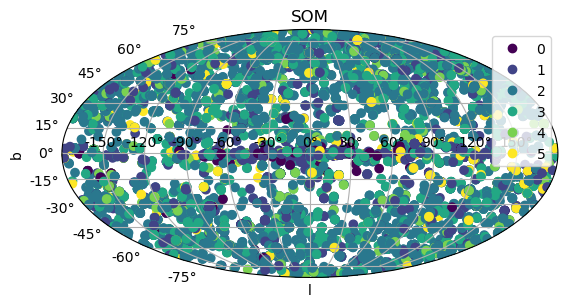

In [9]:
# plotting the clusters
plt.subplot(111, projection='mollweide')
plt.grid(True)
plt.title('SOM')
plt.xlabel('l')
plt.ylabel('b')
scatter = plt.scatter(l_rad, b_rad, c=cluster_index)
plt.legend(handles=scatter.legend_elements()[0], labels=[0, 1, 2, 3, 4, 5])

Meanwhile, this code generates an identical scatter plot, but utilizes the cluster results derived from the Gaussian Mixture Models (GMMs).

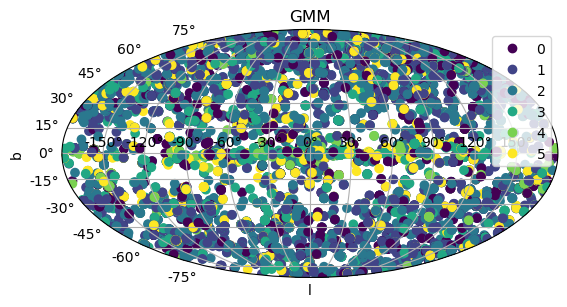

In [10]:
# show the labels restuls
plt.subplot(111, projection='mollweide')
plt.grid(True)
scatter = plt.scatter(l_rad, b_rad, c=GMM_cluster_labels)
plt.xlabel('l')
plt.ylabel('b')
plt.legend(handles=scatter.legend_elements()[0], labels=[0, 1, 2, 3, 4, 5])
plt.title('GMM')
plt.show()

In [11]:
# % of the same cluster vs the same label
print('% of instances where the cluster identified by the SOM matches the one determined by the GMM.')
print(sum(cluster_index == GMM_cluster_labels)/len(cluster_index))
print('% of instances where the cluster identified by the SOM does NOT matche the one determined by the GMM.')
print(sum(cluster_index != GMM_cluster_labels)/len(cluster_index))

% of instances where the cluster identified by the SOM matches the one determined by the GMM.
0.32881470241106053
% of instances where the cluster identified by the SOM does NOT matche the one determined by the GMM.
0.6711852975889395
